# Check scrambling trials

In this notebook, we will check that the trials produced for the correlation analysis are correct.

We produce trials in two ways:
- Scrambling all the sources in r.a.
- Scrambling the sources in r.a. masking the sources that fall into the PAO hotspot.

We do this by plotting the sources and some trials together, to make sure that the randomisation makes sense, and also by checking that there are no duplicate arrays in the trials

In [24]:
# import all the libraries I need

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from astropy.coordinates import AltAz, EarthLocation, SkyCoord, Supergalactic
import matplotlib.cm as cm
import matplotlib as mpl

In [2]:
def GreatCircleDistance(ra_1, dec_1, ra_2, dec_2, unit="rad"):
    """Compute the great circle distance between two events"""
    if unit == "deg":
        ra_1 = np.radians(ra_1)
        ra_2 = np.radians(ra_2)
        dec_1 = np.radians(dec_1)
        dec_2 = np.radians(dec_2)
    delta_dec = np.abs(dec_1 - dec_2)
    delta_ra = np.abs(ra_1 - ra_2)
    x = (np.sin(delta_dec / 2.0)) ** 2.0 + np.cos(dec_1) * np.cos(dec_2) * (
        np.sin(delta_ra / 2.0)
    ) ** 2.0
    return 2.0 * np.arcsin(np.sqrt(x))

In [2]:
trials_AGN = np.load('../../correlation_AGN_allfiles.npy', allow_pickle = True)

In [3]:
trials_all = np.load('../../correlation_allsources_allfiles.npy', allow_pickle = True)

In [8]:
trials_nonAGN = np.load('../../correlation_nonAGN_allfiles.npy', allow_pickle = True)

In [10]:
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.stats import chisquare

In [16]:
from scipy.special import erf, erfinv

def sigma2pval(sigma, oneSided=False):
    r"""Converts gGaussian sigmas into p-values.
    Parameters
    ----------
    sigma : float or array_like
        Gaussian sigmas to be converted in p-values
    oneSided: bool, optional, default=False
        If the sigma should be considered one-sided or two-sided.
    Returns
    -------
    pval : array_like
        p-values.
    """

    pval = 1 - erf(sigma / np.sqrt(2))
    if oneSided:
        pval /= 2.0
    return pval

def pval2sigma(pval, oneSided=False):
    r"""Converts p-values into Gaussian sigmas.
    Parameters
    ----------
    pval : float or array_like
        p-values to be converted in Gaussian sigmas
    oneSided: bool, optional, default=False
        If the p-value should be considered one-sided or two-sided.
    Returns
    -------
    sigma : array_like
        Gaussian sigmas.
    """

    if oneSided:
        pval *= 2.0
    return np.sqrt(2) * erfinv(1 - pval)

In [11]:
def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))


In [12]:
def auto_grid_panels(n_panels):
    """Finds the best grid layout for a given number of panels."""
    cols = math.ceil(math.sqrt(n_panels))
    rows = math.ceil(n_panels / cols)
    return rows, cols

In [13]:
n_bins = 200
bins = np.linspace(0,1,n_bins)

In [14]:
def chi_square(observed, expected):
    return np.sum((observed - expected)**2 / expected)

In [15]:
def plots(trials,ax,i, save_params, mode):
        frac = i + 1
        histo, hedges = np.histogram(trials[f'fraction_{frac:.0f}'], bins = bins)
        bin_centers = (hedges[:-1] + hedges[1:]) / 2
        # Plot the fitted Gaussian
        if mode == 'AGN':
              color_fit = 'dimgrey'
              color_histo = 'C0'
        if mode == 'nonAGN':
              color_fit = 'darkblue'
              color_histo = 'C1'
        if mode == 'all':
                color_fit = 'black'
                color_histo = 'C2'
        if frac != 1:
            x = np.linspace(min(bin_centers), max(bin_centers), 1000)
            
            params, covariance = curve_fit(gaussian, bin_centers, histo, p0=[0, 1, 1])
            mu  , sigma, A = params
            save_params[i] = params
            ax.plot(x, gaussian(x, *params)/np.sum(gaussian(np.linspace(min(bin_centers), max(bin_centers), n_bins-1),*params)), c = color_fit, lw = 1, label=f'{mode} fit')
            
        #normalise histo counts
        histo= histo/ np.sum(histo)
        ax.step(bin_centers, histo, where='mid', alpha=0.3, color = color_histo)
        ax.fill_between(bin_centers, histo, step="mid", alpha=0.3, label = f'{mode} trials', color = color_histo)
        ax.set_xlabel('f[%]')

In [16]:
def plot_panels(n_panels):
    rows, cols = auto_grid_panels(n_panels)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.array(axes).reshape(-1)  # Flatten in case it's 2D
    save_params_AGN = np.zeros((n_panels, 3))
    save_params_nonAGN = np.zeros((n_panels, 3))
    save_params_all = np.zeros((n_panels, 3))
    for i in range(n_panels):
        ax = axes[i]
        plots(trials_AGN,ax, i,save_params_AGN, 'AGN')
        plots(trials_nonAGN,ax,i, save_params_nonAGN, 'nonAGN')
        plots(trials_all,ax,i, save_params_all, 'all')
        ax.text(0.05, 0.95, f'{(i+1):.0f} deg', transform=ax.transAxes, ha='left', va='top')
        
    
    axes[1].legend(frameon = False, bbox_to_anchor = (3, 1.3), ncol = 6)

    # Hide unused axes if any
    for j in range(n_panels, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle('Trials', y = 0.95)
    plt.savefig('plots/test_trials.png', dpi = 300, bbox_inches = 'tight')
    return fig, save_params_AGN, save_params_nonAGN, save_params_all


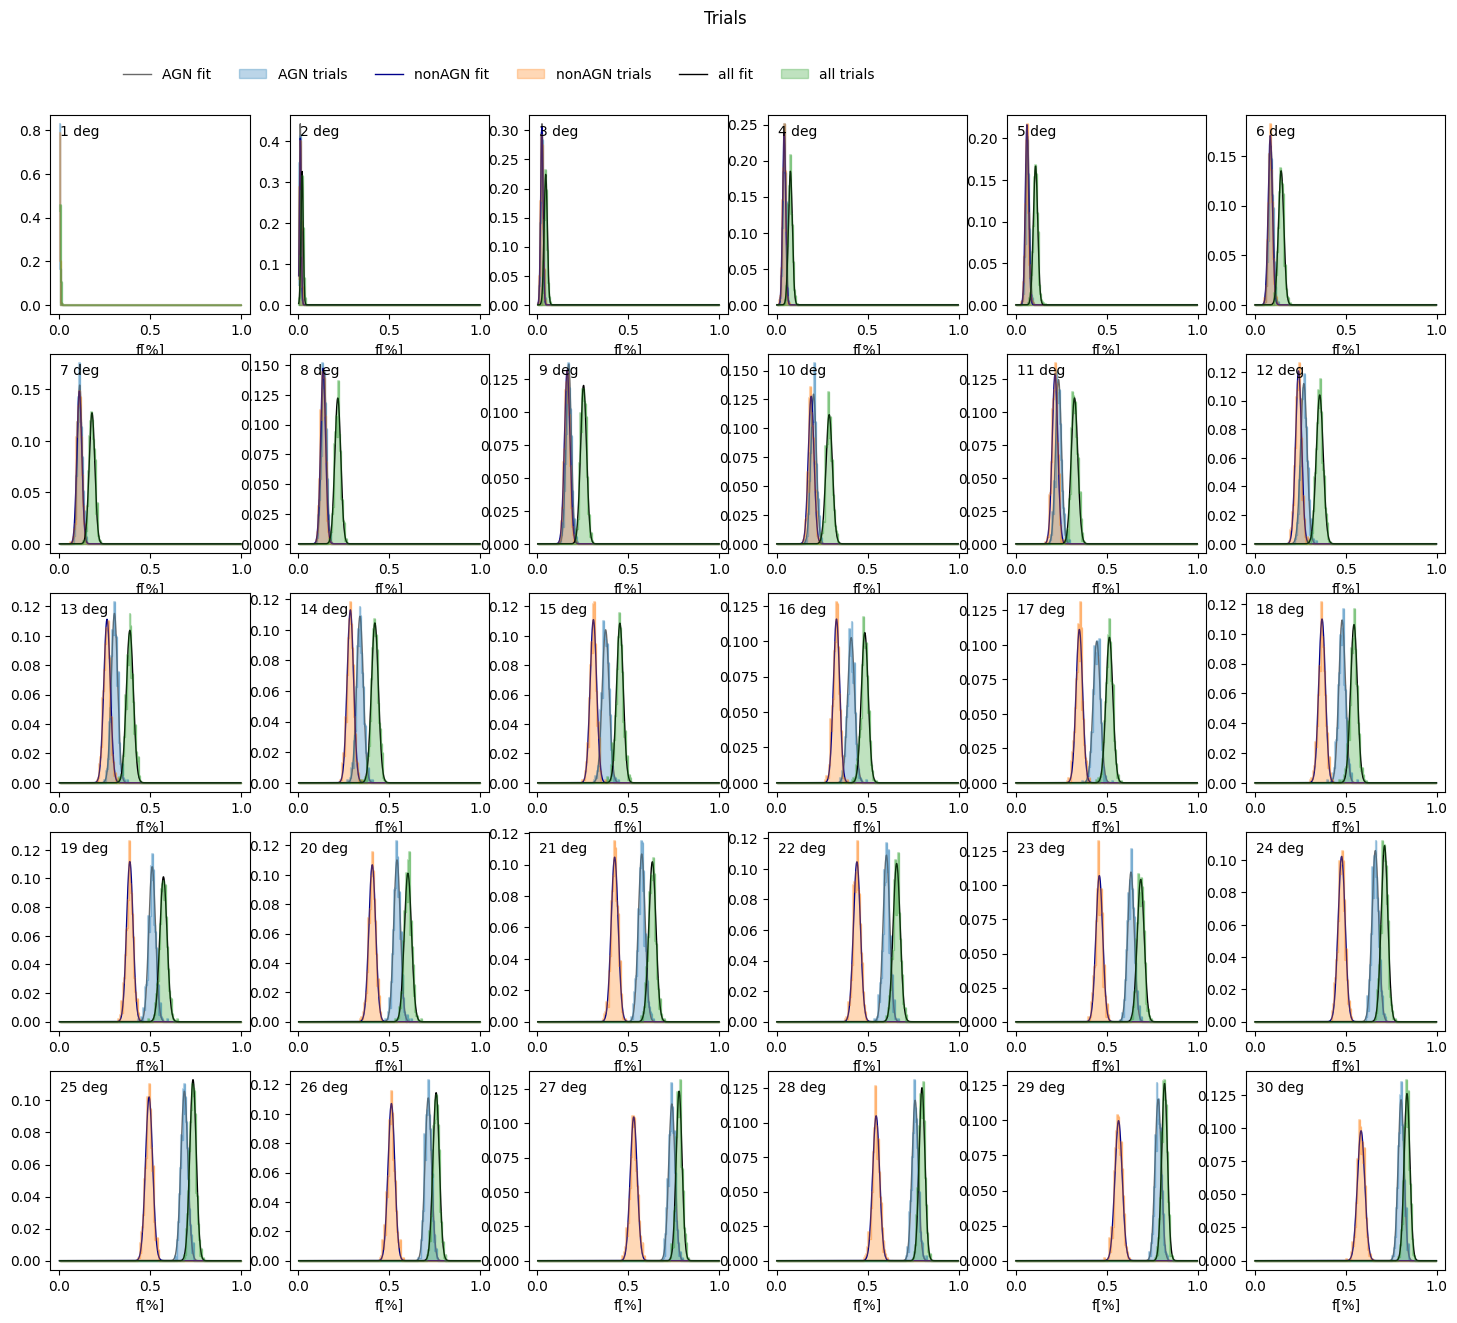

In [17]:
# fig, gaussian_params_AGN, gaussian_params_nonAGN = plot_panels(30)
fig, gaussian_params_AGN, gaussian_params_nonAGN, gaussian_params_all = plot_panels(30)

In [379]:
400/62500

0.0064

In [25]:
def calc_pval(params, data_fraction):
    mu, sigma, A = params
    x = np.linspace(0,1,600)
    norm = np.sum(gaussian(x, mu, sigma, A))
    x_fraction = x[x>=data_fraction]
    fract_above_threshold = np.sum(gaussian(x_fraction, mu, sigma, A)/norm)
    
    return fract_above_threshold

In [415]:
def calc_pval(trials, data_fraction):
    fract_above_threshold = len(trials[trials >= data_fraction])/len(trials)
    
    return fract_above_threshold

In [27]:
fraction = np.arange(2,31,1)
pvals_AGN = np.zeros(len(fraction))
pvals_nonAGN = np.zeros(len(fraction))
pvals_all = np.zeros(len(fraction))

def pvals(gaussian_params):
    sigma = gaussian_params[1]
    mean = gaussian_params[0]
    fractions = np.arange(-0.4,0.5,0.1)
    for f in fractions:
        pvals = np.append(pvals, mean + sigma * f)
    return pvals

In [425]:
for f in fraction:
    pvals = pvals(gaussian_params_AGN[f-1])
    for p in pvals:
        pvals_AGN[f-2] = calc_pval(trials_AGN[f'fraction_{f}'], pvals )
    


In [426]:
p_val_test

0.9968

In [142]:
print(pval2sigma(1))

pval2sigma(0.80, oneSided = True)

0.0


-0.8416212335729144

In [56]:
AGNfiles = glob.glob('../corr_trials/correlation_AGN_initial_seed_*.npy')
nonAGNfiles = glob.glob('../corr_trials/correlation_non_AGN_initial_seed_*.npy')

In [57]:
testAGN = np.concatenate([np.load(f, allow_pickle = True) for f in AGNfiles])
testnonAGN = np.concatenate([np.load(f, allow_pickle = True) for f in nonAGNfiles])

In [58]:
testAGN = testAGN[testAGN['fraction_15']>0]
testnonAGN = testnonAGN[testnonAGN['fraction_15']>0]

In [19]:
import healpy as hp
import pandas as pd

In [21]:
# Set HEALPix resolution
nside = 128  # Adjust as needed
npix = hp.nside2npix(nside)

# Create a HEALPix map (boolean mask for coverage)
coverage_map = np.zeros(npix, dtype=bool)

# Define your regions (example: circular regions at given (ra, dec))
sources = pd.read_hdf('../../sources_coords.h5', key = 'values')

mask_desclination = sources.DEC_deg.values < 44.8
sources = sources[mask_desclination]
mask_active = sources.Activity.values == True
sources_active = sources[mask_active]
sources_nonactive = sources[~mask_active]

radius = 8

# Fill the map with region coverage
for ra, dec in zip(sources.RA_deg.values, sources.DEC_deg.values):
    vec = hp.ang2vec(np.radians(90 - dec), np.radians(ra))  # Convert to HEALPix vector
    pixels = hp.query_disc(nside, vec, np.radians(radius))  # Get pixels in region
    coverage_map[pixels] = True  # Mark as covered

# Compute covered fraction
covered_fraction = np.sum(coverage_map) / npix
print(f"Fraction of sky covered by all the sources at the largest radius: {covered_fraction:.4f}")


coverage_map = np.zeros(npix, dtype=bool)
# Fill the map with region coverage
for ra, dec in zip(sources_active.RA_deg.values, sources_active.DEC_deg.values):
    vec = hp.ang2vec(np.radians(90 - dec), np.radians(ra))  # Convert to HEALPix vector
    pixels = hp.query_disc(nside, vec, np.radians(radius))  # Get pixels in region
    coverage_map[pixels] = True  # Mark as covered

# Compute covered fraction
covered_fraction = np.sum(coverage_map) / npix
print(f"Fraction of sky covered by AGNs at the largest radius: {covered_fraction:.4f}")


coverage_map = np.zeros(npix, dtype=bool)
# Fill the map with region coverage
for ra, dec in zip(sources_nonactive.RA_deg.values, sources_nonactive.DEC_deg.values):
    vec = hp.ang2vec(np.radians(90 - dec), np.radians(ra))  # Convert to HEALPix vector
    pixels = hp.query_disc(nside, vec, np.radians(radius))  # Get pixels in region
    coverage_map[pixels] = True  # Mark as covered

# Compute covered fraction
covered_fraction = np.sum(coverage_map) / npix
print(f"Fraction of sky covered by non AGNs at the largest radius: {covered_fraction:.4f}")


Fraction of sky covered by all the sources at the largest radius: 0.2247
Fraction of sky covered by AGNs at the largest radius: 0.1397
Fraction of sky covered by non AGNs at the largest radius: 0.1412


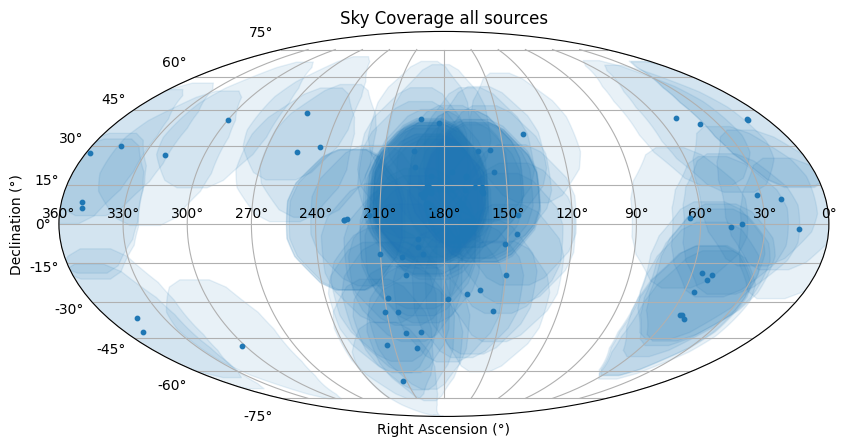

In [212]:

# Plot with matplotlib
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="mollweide")
for ra, dec in zip(sources.RA_deg.values, sources.DEC_deg.values):
    ax.scatter(-np.radians(ra)+np.pi, np.radians(dec), c="C0", s=10, zorder = 100)
    circle = plt.Circle((-np.radians(ra)+np.pi, np.radians(dec)), np.radians(27), color = 'C0', alpha = 0.1)

    ax.add_patch(circle)

# Labels and formatting
plt.xlabel("Right Ascension (°)")
plt.ylabel("Declination (°)")
plt.title("Sky Coverage all sources")
plt.grid(True)
xticks = np.radians(np.linspace(-180, 180, 13))  # Tick locations in radians
xtick_labels = [f"{int(x)}°" for x in np.linspace(360, 0, 13)]  # Tick labels in degrees
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)  # Set the tick labels

plt.show()


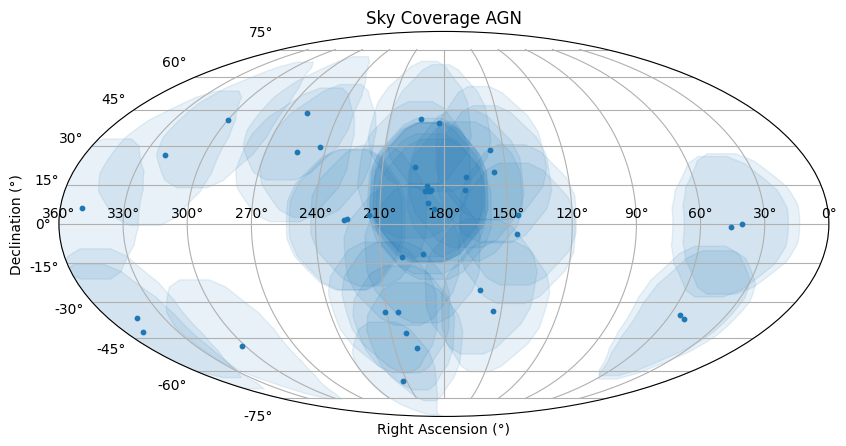

In [213]:

# Plot with matplotlib
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="mollweide")
for ra, dec in zip(sources_active.RA_deg.values, sources_active.DEC_deg.values):
    ax.scatter(-np.radians(ra)+np.pi, np.radians(dec), c="C0", s=10, zorder = 100)
    circle = plt.Circle((-np.radians(ra)+np.pi, np.radians(dec)), np.radians(27), color = 'C0', alpha = 0.1)

    ax.add_patch(circle)

# Labels and formatting
plt.xlabel("Right Ascension (°)")
plt.ylabel("Declination (°)")
plt.title("Sky Coverage AGN")
plt.grid(True)
xticks = np.radians(np.linspace(-180, 180, 13))  # Tick locations in radians
xtick_labels = [f"{int(x)}°" for x in np.linspace(360, 0, 13)]  # Tick labels in degrees
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)  # Set the tick labels

plt.show()


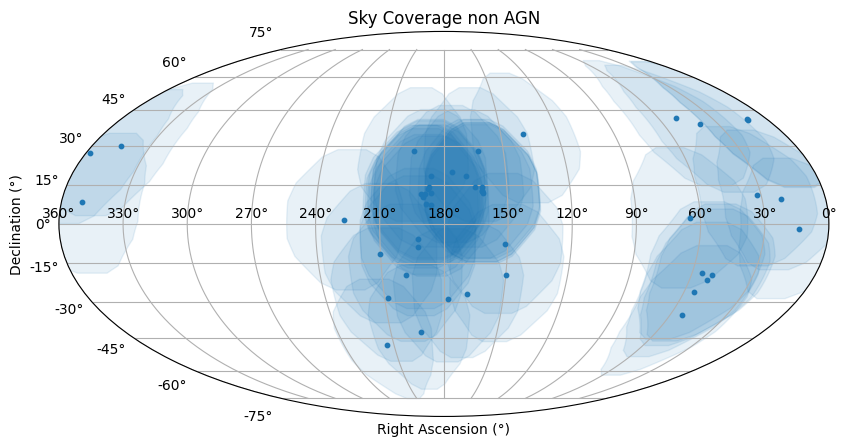

In [214]:

# Plot with matplotlib
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="mollweide")
for ra, dec in zip(sources_nonactive.RA_deg.values, sources_nonactive.DEC_deg.values):
    ax.scatter(-np.radians(ra)+np.pi, np.radians(dec), c="C0", s=10, zorder = 100)
    circle = plt.Circle((-np.radians(ra)+np.pi, np.radians(dec)), np.radians(27), color = 'C0', alpha = 0.1)

    ax.add_patch(circle)

# Labels and formatting
plt.xlabel("Right Ascension (°)")
plt.ylabel("Declination (°)")
plt.title("Sky Coverage non AGN")
plt.grid(True)
xticks = np.radians(np.linspace(-180, 180, 13))  # Tick locations in radians
xtick_labels = [f"{int(x)}°" for x in np.linspace(360, 0, 13)]  # Tick labels in degrees
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)  # Set the tick labels

plt.show()


In [22]:
0.86*607

522.02

In [23]:
540/607

0.8896210873146623